### Data Import and Setup

In this section, we import the necessary libraries and load the dataset to prepare it for preprocessing. Techniques established in the [Exploring Data Notebook](ExploringData.ipynb) are reused here.


In [1]:
#importing libraries

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import shap



In [2]:
# Load the data
df = pd.read_csv('../data/fake_reviews_dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


### Data Preparation
- **Remove the `category` feature**: This limits the model's usability for applications without categorical data.  
- **Convert the `label` field to binary**: Map the `label` field to 1 (CG) and 0 (OR) for compatibility with binary classification models.  
- **Add a `sentiment` feature**: Use sentiment analysis to extract the tone (positive, neutral, or negative) from the review text, providing an additional feature for classification.


In [3]:
# Convert label to binary
df['label_binary'] = df['label'].map({'CG': 1, 'OR': 0})
#remove the original label column
df = df.drop(columns=['label'])

#drop category column as it limits the usability of the model to only applications with catgories.
df = df.drop(columns=['category'])

# Display the dataframe with the new binary label column
df.head(10)

,rating,text_,label_binary
0,5.0,"Love this! Well made, sturdy, and very comfor...",1
1,5.0,"love it, a great upgrade from the original. I...",1
2,5.0,This pillow saved my back. I love the look and...,1
3,1.0,"Missing information on how to use it, but it i...",1
4,5.0,Very nice set. Good quality. We have had the s...,1
5,3.0,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.,1
6,5.0,They are the perfect touch for me and the only...,1
7,3.0,These done fit well and look great. I love th...,1
8,5.0,"Great big numbers & easy to read, the only thi...",1
9,5.0,My son loves this comforter and it is very wel...,1


In [4]:
# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores for each review
def get_sentiment_scores(text):
    sentiment = sentiment_analyzer.polarity_scores(text)
    return sentiment['compound']  # Using the compound score as it summarizes sentiment

# Apply the function to the 'cleaned_text' column
df['sentiment_score'] = df['text_'].apply(get_sentiment_scores)

# Display the updated dataframe
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,rating,text_,label_binary,sentiment_score
0,5.0,"Love this! Well made, sturdy, and very comfor...",1,0.9593
1,5.0,"love it, a great upgrade from the original. I...",1,0.8910
2,5.0,This pillow saved my back. I love the look and...,1,0.7906
3,1.0,"Missing information on how to use it, but it i...",1,0.7463
4,5.0,Very nice set. Good quality. We have had the s...,1,0.7397


#### Preprocess Text Fields  
Prepare text for vectorization by:  
- **Removing punctuation**: Ensures the text focuses on meaningful words by eliminating unnecessary symbols that don’t contribute to understanding context.  
- **Converting to lowercase**: Standardizes text to avoid treating words like "Apple" and "apple" as different features.  
- **Removing stopwords**: Eliminates common, non-informative words (e.g., "and," "the") that can dilute the significance of more meaningful terms.


In [5]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back to a single string
    return ' '.join(tokens)

# Apply preprocessing to the "text_" column
df['cleaned_text'] = df['text_'].apply(preprocess_text)

# Drop the original text column
df = df.drop(columns=['text_'])

# Display the dataframe with the new cleaned text column
df.head(10)


[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/andy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,rating,label_binary,sentiment_score,cleaned_text
0,5.0,1,0.9593,love well made sturdy comfortable love itvery ...
1,5.0,1,0.8910,love great upgrade original ive mine couple year
2,5.0,1,0.7906,pillow saved back love look feel pillow
3,1.0,1,0.7463,missing information use great product price
4,5.0,1,0.7397,nice set good quality set two month
5,3.0,1,0.0000,wanted different flavor
6,5.0,1,0.7506,perfect touch thing wish little space
7,3.0,1,0.9169,done fit well look great love smoothness edge ...
8,5.0,1,0.7087,great big number easy read thing didnt like size
9,5.0,1,0.8580,son love comforter well made also baby


#### Data Setup  
Split the data into train and test datasets to:  
- **Train the model**: Use the training set to teach the model to recognize patterns in the data.  
- **Test the model**: Evaluate the model's performance on unseen data to measure its ability to generalize to new inputs.  


In [6]:
# Split the dataset into text feature, additional features, and target
X = df[['cleaned_text', 'rating', 'sentiment_score']]  # Assuming 'text' is the text column
y = df['label_binary']  # Target column
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


#### Train the Model  
Train the model with optimal hyperparameters determined using **GridSearchCV**:  
- **Why GridSearchCV?**: This process tests multiple combinations of hyperparameters (e.g., `C`, `gamma`, `kernel`) to find the best-performing configuration.  
- **Pipeline**: Combines `TfidfVectorizer` for text vectorization and `SVC` (Support Vector Classifier) with chosen hyperparameters for classification.  
- **Training and Testing**: The model is trained on the training set and evaluated on the test set to assess accuracy and generate a classification report.  

This ensures the model achieves high performance by leveraging an optimized configuration for text classification tasks.

In [7]:
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(C=10, gamma='scale', kernel='rbf'))
])

# Train the model
pipeline.fit(x_train['cleaned_text'], y_train)

# Predict on the test set
y_pred = pipeline.predict(x_test['cleaned_text'])

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      5070
           1       0.91      0.88      0.89      5038

    accuracy                           0.89     10108
   macro avg       0.89      0.89      0.89     10108
weighted avg       0.89      0.89      0.89     10108

Accuracy: 0.8946379105658884


### Model Evaluation

- **Accuracy**: Measures the overall correctness of predictions.
- **Precision**: Focuses on how many predicted positives were correct.
- **Recall**: Indicates how well the model identifies true positives.


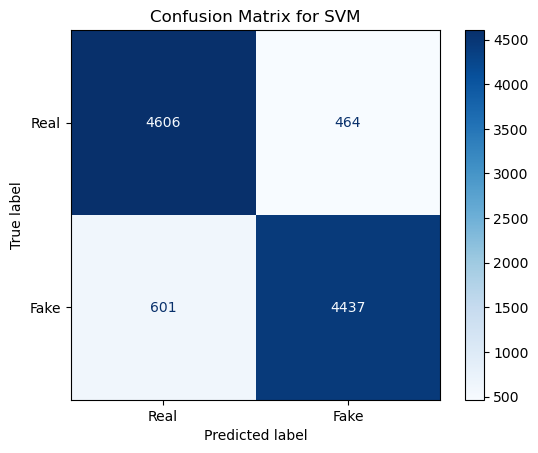

In [8]:
# Confusion matrix for non-fake reviews (0)
cm_non_fake = confusion_matrix(y_test, y_pred)
disp_non_fake = ConfusionMatrixDisplay(confusion_matrix=cm_non_fake, display_labels=['Real', 'Fake'])
disp_non_fake.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()


#### Receiver Operating Characteristic (ROC) Curve  
This graph evaluates the model's ability to distinguish between classes:  

- **True Positive Rate (TPR)**: The proportion of actual positives correctly identified (sensitivity).  
- **False Positive Rate (FPR)**: The proportion of negatives incorrectly identified as positives.  

**Key Insights:**  
- The **curve's shape** shows how well the model balances between TPR and FPR. A curve closer to the top-left corner indicates better performance.  
- **AUC (Area Under Curve)**: A score of **0.96** means the model is excellent at distinguishing between classes. A perfect model would score 1.0, while a random guess would score 0.5.  

This high AUC value suggests the model is very effective at predicting the correct labels.

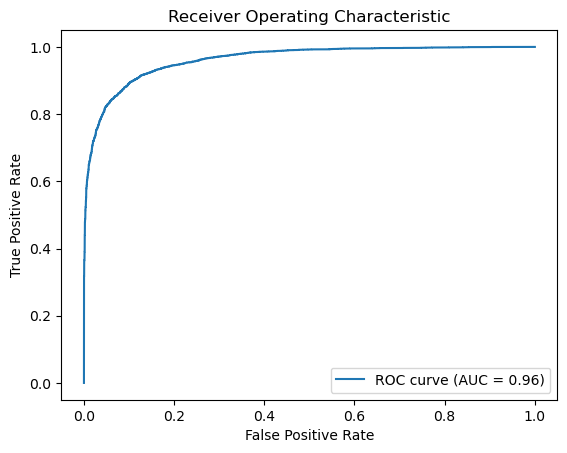

In [9]:
# Binarize labels if it's not already binary
y_test_binary = label_binarize(y_test, classes=pipeline.classes_)

# Get probabilities from the model
y_scores = pipeline.decision_function(x_test['cleaned_text'])

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()


#### Error Analysis  

Error analysis helps identify where the model struggles by examining misclassified examples:  

- **True Label vs. Predicted Label**: This comparison shows instances where the model’s prediction differs from the correct label.  
- **Text Review**: By analyzing the actual text of misclassified samples, we can understand whether errors result from ambiguous input, limitations in training data, or challenges inherent to the problem.  

**Key Insights from Example Misclassifications:**  
- **Patterns in Errors**: Are certain labels consistently misclassified? If so, it might indicate a need for more training data for those labels.  
- **Ambiguity**: Text that could logically fit multiple labels might reflect the inherent complexity of the task.  
- **Outliers**: Rare or unusual inputs might not be well-represented in the training data.  

This process highlights areas where the model can improve, such as refining the dataset, adjusting hyperparameters, or exploring alternative modeling approaches.

In [10]:
# Identify misclassified samples
misclassified_indices = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred[i]]

# Print some examples
for index in misclassified_indices[:5]:  # Display the first 5 misclassified samples
    print(f"True Label: {y_test.iloc[index]}, Predicted Label: {y_pred[index]}")
    print(f"Text: {x_test.iloc[index]['cleaned_text']}\n")

True Label: 1, Predicted Label: 0
Text: lee child hit bullseye force reader dramatic turn event story follows story grandfather father grandson grandson mother detailed account life grandfather father grandson mother told story well researched story told eye detail highly recommend booki disappointed always fan robert langdons book series really lacking since kid series always little different others still one best ive read

True Label: 0, Predicted Label: 1
Text: 1 year old baby love itit little bit short many review said still interesting

True Label: 0, Predicted Label: 1
Text: perfect fit great price revived helmet functional use beat buying new helmet helmet excellent condition

True Label: 0, Predicted Label: 1
Text: sorry see product made china discovery bad dog food china addition thing lead paint childrens toy dont feel completely confident treat harmful

True Label: 1, Predicted Label: 0
Text: good value chuggington train go track make great gift

